In [53]:
# Setup

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

import utils


REPO_DIR = os.path.dirname(os.path.abspath("__file__"))
STORAGE_DIR = os.path.join(REPO_DIR, 'storage')
PLOTS_DIR = os.path.join(REPO_DIR, 'plots')

In [ ]:
# Settings

aggregation = 'all'

logdirs = [
    'LTL2Action_comparison_Dataset/train',
    'LTL2Action_comparison_Dataset/eval-Dataset_e54test',
    'LTL2Action_comparison_Dataset/eval-Dataset_e54test-argmax',
    'LTL2Action_comparison_Dataset/eval-Dataset_e65test',
    'LTL2Action_comparison_Dataset/eval-Dataset_e65test-argmax',
    'LTL2Action_comparison_Dataset/eval-Eventually_1_5_1_4-argmax',
    'LTL2Action_comparison_Dataset/eval-Eventually_6_6_5_5-argmax',
]

tag = 'average_discounted_return'

smoothings = []
labels = []

plot_name = 'plot'
xlabel = 'Step'
ylabel = 'Value'
title = 'title'

In [ ]:
# Utility Functions

def load_scalars(logdir, tag):
    ea = event_accumulator.EventAccumulator(logdir)
    ea.Reload()
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return dict(zip(steps, values))


def compute_average(datas):

    common_steps = set.intersection(*[set(d.keys()) for d in datas])
    common_steps = sorted(common_steps)

    averaged = []
    for step in common_steps:
        values = [d[step] for d in datas]
        avg = np.mean(values)
        averaged.append((step, avg))

    steps, values = zip(*averaged)
    return dict(zip(steps, values))


def smooth(values, alpha=0.9):
    smoothed = []
    last = values[0]
    for v in values:
        last = alpha * last + (1 - alpha) * v
        smoothed.append(last)
    return smoothed


def save_plot(plt, name):
    os.makedirs(PLOTS_DIR, exist_ok=True)
    plt.savefig(os.path.join(PLOTS_DIR, f'{name}.png'))


def infer_labels(logdirs):
    return [logdir.split('/')[-1] for logdir in logdirs]


def default_smoothings(logdirs):
    return [0.0 for _ in range(len(logdirs))]

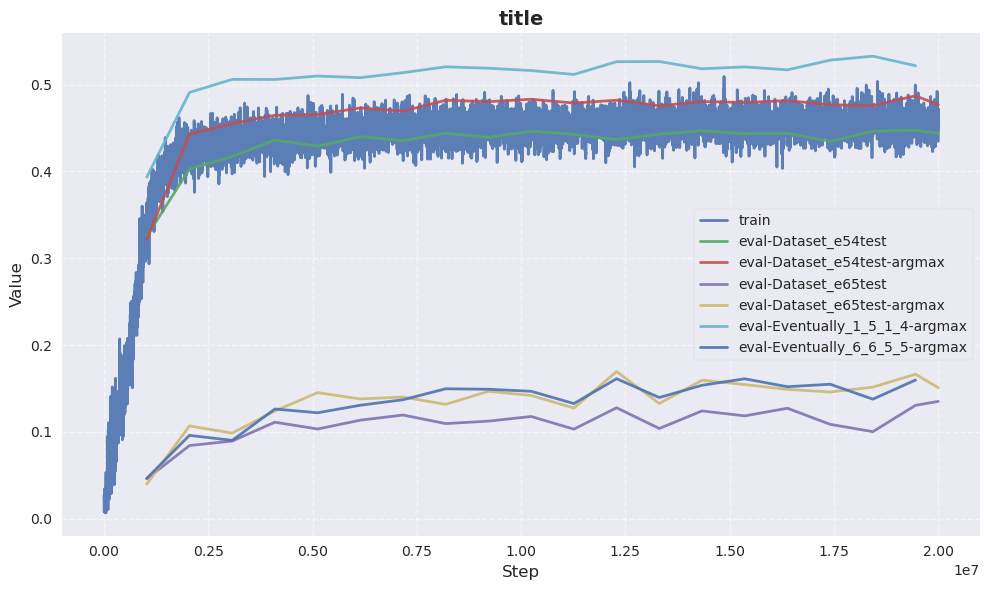

In [ ]:
plt.style.use("seaborn")
plt.figure(figsize=(10, 6))

datas = []

if labels == []:
    labels = infer_labels(logdirs)

if smoothings == []:
    smoothings = default_smoothings(logdirs)


for logdir in logdirs:
    logdir = os.path.join(STORAGE_DIR, logdir)
    data = load_scalars(logdir, tag)
    datas.append(data)


if aggregation == 'all':
    for i, (logdir, data) in enumerate(zip(logdirs, datas)):
        steps, values = list(data.keys()), list(data.values())
        values = smooth(values, smoothings[i])
        plt.plot(
            steps, values,
            label=labels[i],
            linewidth=2,
            alpha=0.9
        )


elif aggregation == 'mean':
    averaged = compute_average(datas)
    steps, values = list(averaged.keys()), list(averaged.values())
    plt.plot(
        steps, values,
        label=labels[0],
        linewidth=2,
        marker="o",
        markersize=4
    )


plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.title(title, fontsize=14, weight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best", fontsize=10, frameon=True)
plt.tight_layout()

save_plot(plt, plot_name)
plt.show()